In [19]:
def dist(a, b):
    return ((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)**.5

In [12]:
from scipy.optimize import NonlinearConstraint

def dynamics(state, inputs):
    """
    Simple kinematic bicycle model for dynamics simulation.
    
    Args:
    - state (array): Current state [x, y, theta, velocity].
    - inputs (array): Control inputs [angle, velocity].
    
    Returns:
    - next_state (array): Next state [x, y, theta, velocity].
    """
    x, y, theta, velocity = state
    angle, v = inputs
    
    L = 1.0  # Length of the vehicle
    
    x_dot = velocity * np.cos(theta)
    y_dot = velocity * np.sin(theta)
    theta_dot = velocity * np.tan(angle) / L
    velocity_dot = 0.0
    
    next_state = np.array([
        x + x_dot * dT,
        y + y_dot * dT,
        theta + theta_dot * dT,
        velocity + velocity_dot * dT
    ])
    
    return next_state

In [20]:
# CARTESIAN KINEMATICS
def dynamics(state, action, dT):
    x, y, vel_x, vel_y = state
    a_x, a_y = action

    vel_x += a_x * dT
    vel_y += a_y * dT
    x += vel_x * dT
    y += vel_y * dT

    return np.array( [ x, y, vel_x, vel_y ] )

In [30]:
import numpy as np

initial_state = np.array([0.0, 0.0, 0.0, 0.0])  # [x, y, theta, velocity]
goal_state = np.array([10.0, 15.0, 0.0, 0.0])

waypoints = np.array([[1, 4], [5, 9], [8, 13], [10, 15]])

obstacles = [ (2, 2, 1), (4, 4, 2) ] # Obstacle at 6,6 with radius 1
# obstacles = []

N = 50  # Number of timesteps
dT = 0.1  # Time step size

initial_guess = np.array([waypoints[0][0] - initial_state[0], waypoints[0][1] - initial_state[1]])  / dT / 50  # Accel_X, Accel_Y

print(initial_guess)

[0.2 0.8]


In [27]:
def final_state_cost(state):
    global goal_state

    # x_dist = dist(state, goal_state)
    
    x_dist = (state[0] - goal_state[0]) ** 2
    y_dist = (state[1] - goal_state[1]) ** 2
    vx_dist = (state[2] - goal_state[2]) ** 2
    vy_dist = (state[3] - goal_state[3]) ** 2

    return x_dist + y_dist + vx_dist + vy_dist

def state_cost(state):
    global obstacles

    cost = 0

    if state[2] > 10 or state[2] < 0:
        cost += 100

    if state[3] > 10 or state[3] < 0:
        cost += 100

    for obstacle in obstacles:
        if dist(state, obstacle) <= obstacle[2]:
            cost += 100
            # return (obstacle[2]/dist(state, obstacle)) * 100

    return cost

def constraint_function(actions):
    global initial_state
    global dT
    state = initial_state
    actions = np.reshape(actions, (-1, 2))
    
    cost = 0.0

    for action in actions:
        cost += state_cost(state)
        state = dynamics(state, action, dT)

    cost += state_cost(state)

    return cost

constraint = NonlinearConstraint(constraint_function, lb=0, ub=0)

def cost_function(actions):
    """
    Cost function to be minimized. 
    
    Args:
    - inputs (array): Control inputs [angle, velocity].
    
    Returns:
    - cost (float): Cost associated with the inputs.
    """
    global initial_state
    global dT
    state = initial_state
    actions = np.reshape(actions, (-1, 2))
    
    cost = 0.0

    for action in actions:
        # cost += state_cost(state)
        state = dynamics(state, action, dT)

    cost += final_state_cost(state)

    return cost

In [28]:
import numpy as np
from scipy.optimize import minimize


def calculate_optimal_input(goal_state, initial_guess, N, dT):
    # N actions
    # N+1 states
    actions = np.array( [initial_guess for i in range(N)] )
    actions = actions.flatten()
    
    bounds = [ (-10.0, 10.0) for i in range(N * 2) ]
    
    # Minimize the cost function
    result = minimize(cost_function, actions, constraints=constraint, bounds=bounds)
    
    optimal_inputs = result.x
    return optimal_inputs

optimal_inputs = calculate_optimal_input(goal_state, initial_guess, N, dT)
print("Optimal inputs:", optimal_inputs)

actions = np.reshape(optimal_inputs, (-1, 2))
state = initial_state
for i in actions:
    state = dynamics(state, i, dT)

print(state)

Optimal inputs: [0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8
 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8
 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8
 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8
 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8
 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.2 0.8]
[ 2.55 10.2   1.    4.  ]


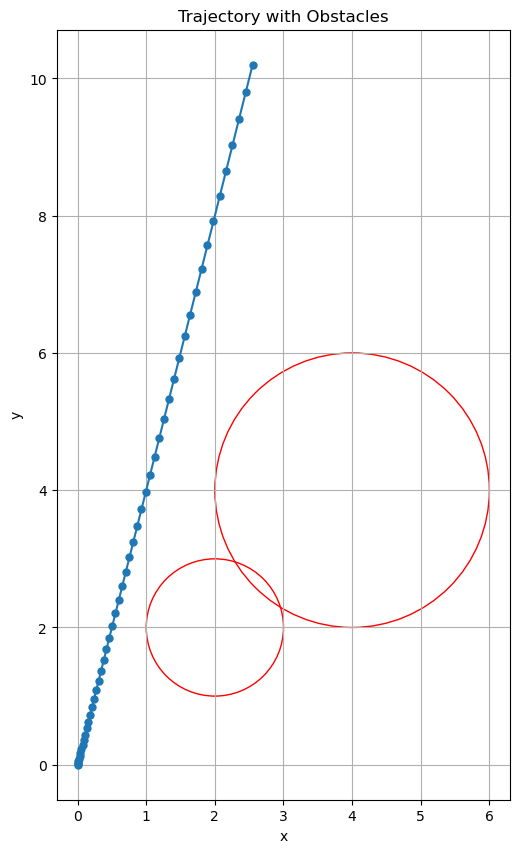

In [29]:
import matplotlib.pyplot as plt

# Calculate optimal inputs
optimal_actions = np.reshape(optimal_inputs, (-1, 2))
states = [initial_state]
for action in optimal_actions:
    states.append(dynamics(states[-1], action, dT))

# Extracting x, y, vx, vy from states
x = [state[0] for state in states]
y = [state[1] for state in states]
vx = [state[2] for state in states]
vy = [state[3] for state in states]

# Calculating ax and ay
ax = [(vx[i+1] - vx[i]) / dT for i in range(len(vx)-1)]
ay = [(vy[i+1] - vy[i]) / dT for i in range(len(vy)-1)]

# Plotting
plt.figure(figsize=(12, 10))

# Plotting trajectory on a coordinate grid
# plt.subplot(3, 1, 1)
plt.plot(x, y, marker='o', linestyle='-', markersize=5)
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', fill=False)
    plt.gca().add_patch(circle)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory with Obstacles')
plt.grid(True)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# plt.subplot(3, 1, 2)
# plt.plot(vx, label='vx')
# plt.plot(vy, label='vy')
# plt.legend()
# plt.grid(True)
# plt.title('Velocity')

# plt.subplot(3, 1, 3)
# plt.plot(ax, label='ax')
# plt.plot(ay, label='ay')
# plt.legend()
# plt.grid(True)
# plt.title('Acceleration')

# plt.tight_layout()
# plt.show()